## Описание набора данных

В этом соревновании мы классифицируем распространённые заболевания грудной клетки лёгких и локализуем критические признаки. Это задача на обнаружение и классификацию объектов.

Для каждого тестового изображения вы будете прогнозировать ограничивающую рамку и класс для всех результатов. Если вы прогнозируете отсутствие результатов, следует создать прогноз «14 1 0 0 1 1» (14 — это идентификатор класса, соответствующий отсутствию результатов, что обеспечивает ограничивающую рамку шириной в один пиксель с достоверностью 1,0).

Изображения имеют формат DICOM, что означает, что они содержат дополнительные данные, которые могут быть полезны для визуализации и классификации.

---

### Информация о наборе данных

Набор данных включает **18 000 рентгенограмм грудной клетки** в задне-передней проекции (ПЗП) в формате **DICOM**, которые были деперсонифицированы для защиты конфиденциальности пациентов.  
Все изображения были промаркированы группой опытных рентгенологов на предмет наличия **14 критических рентгенологических признаков**, перечисленных ниже:

- 0 — Aortic enlargement  
- 1 — Atelectasis  
- 2 — Calcification  
- 3 — Cardiomegaly  
- 4 — Consolidation  
- 5 — ILD  
- 6 — Infiltration  
- 7 — Lung Opacity  
- 8 — Nodule/Mass  
- 9 — Other lesion  
- 10 — Pleural effusion  
- 11 — Pleural thickening  
- 12 — Pneumothorax  
- 13 — Pulmonary fibrosis  
- 14 — No finding (отсутствие всех находок)

Наблюдение «Нет результатов» (14) было призвано зафиксировать отсутствие всех указанных выше результатов.  
Обратите внимание, что ключевой частью этого конкурса является работа с данными, полученными от нескольких рентгенологов.

---

### Файлы

- **train.csv** — метаданные тренировочного набора, содержащие по одной строке для каждого объекта, включая класс и ограничивающий прямоугольник.  
  Некоторые изображения как в тестовом, так и в тренировочном наборе содержат несколько объектов.  
- **sample_submission.csv** — файл образца отправки в правильном формате.

---

### Колонки в train.csv

- `image_id` — уникальный идентификатор изображения  
- `class_name` — наименование класса обнаруженного объекта (или «Не обнаружено»)  
- `class_id` — идентификатор класса обнаруженного объекта  
- `rad_id` — удостоверение личности рентгенолога, проводившего наблюдение  
- `x_min` — минимальная координата X ограничивающей рамки объекта  
- `y_min` — минимальная координата Y ограничивающей рамки объекта  
- `x_max` — максимальная координата X ограничивающего прямоугольника объекта  
- `y_max` — максимальная координата Y ограничивающего прямоугольника объекта


DICOM (Digital Imaging and Communications in Medicine) — это медицинский формат изображений, хранящий не только сам пиксельный снимок, но и встроенные метаданные

train.csv
Это основная таблица аннотаций, где каждая строка — это отдельный объект (bounding box) на изображении.
Если на одном снимке несколько находок (например, «Pleural effusion» и «Nodule»), то он встречается несколько раз.

sample_submission.csv
Файл-шаблон для финальной отправки на Kaggle.
Он нужен только чтобы понять формат вывода.

## План ноутбука

### I. Обоснование разбиения задачи на подэтапы
Коротко описываем, почему задачу можно разбить на три шага (бинарная классификация всего изображения→ детекция → классификация областей).  
Приводим блок-схему и основные плюсы/минусы подхода.

### II. Возможные признаки, извлекаемые из изображений
Перечисляем, какие признаки можно вычленить из изображенный, которые пригодятся на каждом из трех шагов

### III. Сбор и отбор метаданных DICOM-изображений
Анализируем какие DICOM-теги присутствуют в train и test изображениях.  
Оставляем только стабильные и полезные признаки, предобрабатываем их.

### IV. Формирование бинарной целевой переменной
Определяем, как строится таргет для бинарной классификации  
0 — все аннотации "No finding",  
1 — есть хотя бы одна патология.

### V. Извлечение признаков из изображений (HOG, LBP, GLCM)
Создаём отдельный набор признаков на основе пиксельной информации изображений  
Сохраняем файловые наборы: `x_train_image_features.csv` и `x_test_image_features.csv`.

### Итог
К концу ноутбука получаем:
— очищенные метаданные,  
— таргет,  
— признаки изображений,  
— полностью подготовленный датасет для построения бинарной ML-модели.

In [171]:
import os
import json
import collections
import ntpath
import warnings
import itertools

import numpy as np
import pandas as pd
import kagglehub

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb
import seaborn as sns

import pydicom
from pydicom.datadict import keyword_for_tag

from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.feature.texture import graycomatrix, graycoprops

from tqdm import tqdm
from joblib import Parallel, delayed

# === Полное подавление предупреждений ===
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore")

## I. Обоснование разбивки задачи на подэтапы (включая импорт данных + повтор ключевых выводов из EDA для бейслайн-модели)

In [10]:

# # config_path = "/Users/mark/Downloads/kaggle.json"  # поправь путь

# with open(config_path, "r") as f:
#     cfg = json.load(f)

# os.environ["KAGGLE_USERNAME"] = cfg["username"]
# os.environ["KAGGLE_KEY"] = cfg["key"]

# kagglehub.login()

# data_dir = kagglehub.competition_download(
#     "vinbigdata-chest-xray-abnormalities-detection"
# )

In [12]:
data_dir='/Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection'

In [86]:
train_csv_path = os.path.join(data_dir, "train.csv")
dicom_train_dir = os.path.join(data_dir, "train")
dicom_test_dir = os.path.join(data_dir, "test")

In [16]:
df = pd.read_csv(os.path.join(data_dir, "train.csv"))

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", font_scale=1.1)

df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


Уникальных снимков: 15000
Среднее количество разметок на снимок: 4.5276
Медиана разметок на снимок: 3.0
Максимум разметок: 57


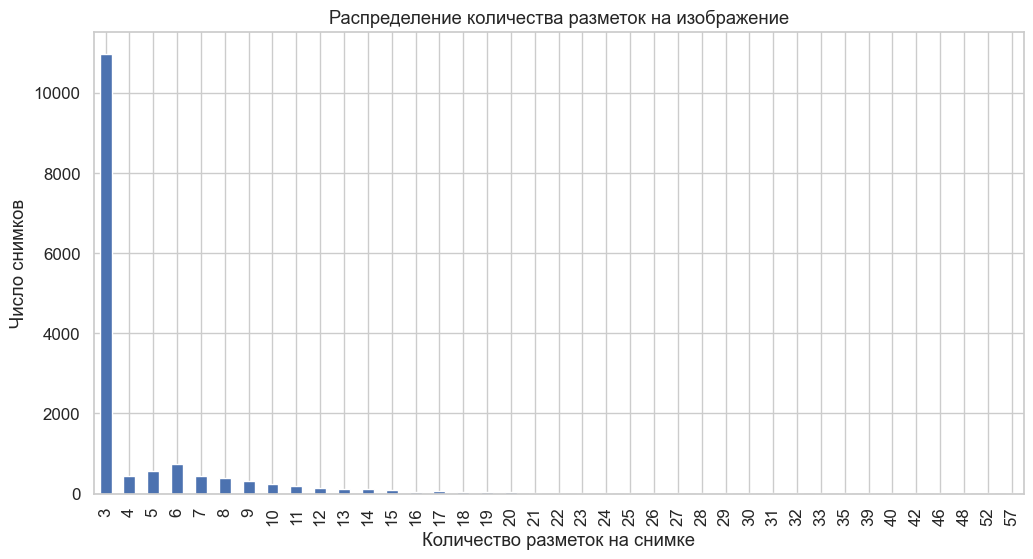

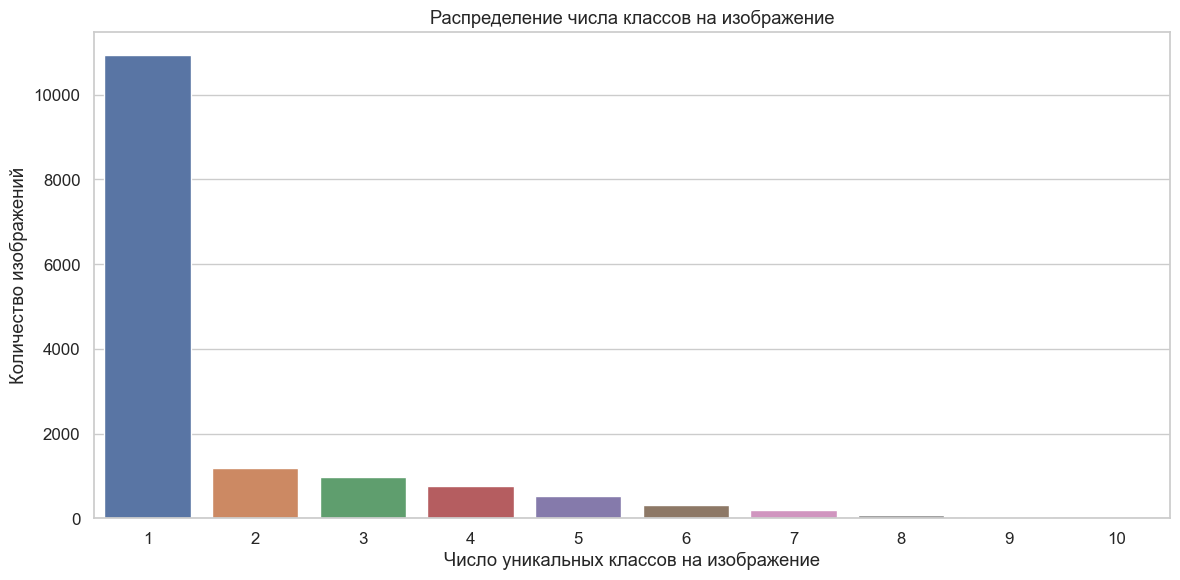

Медиана числа классов на снимок: 1.0
Максимальное число классов на снимок: 10


In [18]:
groups_by_image_id = df.groupby("image_id")["class_id"].count()

print("Уникальных снимков:", df["image_id"].nunique())
print("Среднее количество разметок на снимок:", groups_by_image_id.mean())
print("Медиана разметок на снимок:", groups_by_image_id.median())
print("Максимум разметок:", groups_by_image_id.max())

plt.figure(figsize=(12, 6))
groups_by_image_id.value_counts().sort_index().plot(kind="bar")
plt.xlabel("Количество разметок на снимке")
plt.ylabel("Число снимков")
plt.title("Распределение количества разметок на изображение")
plt.show()

classes_per_image = df.groupby("image_id")["class_name"].nunique()
classes_count = classes_per_image.value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=classes_count.index.astype(str),
    y=classes_count.values
)
plt.xlabel("Число уникальных классов на изображение")
plt.ylabel("Количество изображений")
plt.title("Распределение числа классов на изображение")
plt.tight_layout()
plt.show()

print("Медиана числа классов на снимок:", classes_per_image.median())
print("Максимальное число классов на снимок:", classes_per_image.max())

Уникальных радиологов: 17
rad_id
R8     6582
R10    6467
R9     6125
R2     3119
R5     2783
R3     2285
R6     2041
R1     1995
R7     1733
R16    1676
R12    1671
R15    1639
R13    1629
R11    1526
R4     1513
R14    1440
R17     776
Name: image_id, dtype: int64


,rad_id,n_unique_images
0,R8,6582
1,R10,6467
2,R9,6125
3,R2,3119
4,R5,2783
5,R3,2285
6,R6,2041
7,R1,1995
8,R7,1733
9,R16,1676


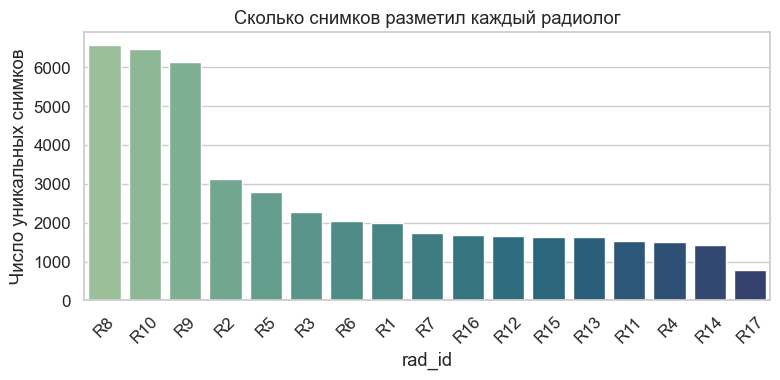

Число уникальных снимков на класс:
class_name
No finding            10606
Aortic enlargement     3067
Cardiomegaly           2300
Pleural thickening     1981
Pulmonary fibrosis     1617
Lung Opacity           1322
Other lesion           1134
Pleural effusion       1032
Nodule/Mass             826
Infiltration            613
Calcification           452
ILD                     386
Consolidation           353
Atelectasis             186
Pneumothorax             96
Name: image_id, dtype: int64


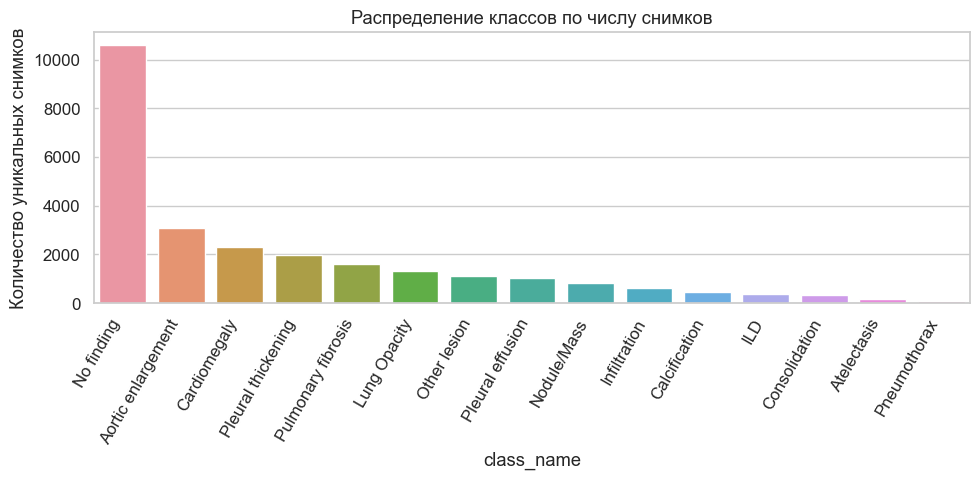

Всего снимков: 15000
Только 'No finding': 10606
Есть патологии: 4394


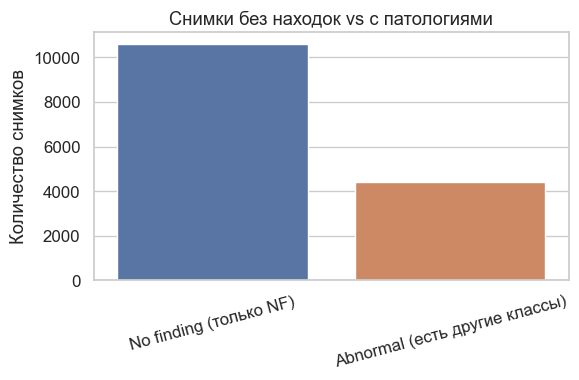

In [19]:
images_per_rad = (
    df.groupby("rad_id")["image_id"]
      .nunique()
      .sort_values(ascending=False)
)

print("Уникальных радиологов:", df["rad_id"].nunique())
print(images_per_rad)

rad_image_table = (
    images_per_rad.reset_index()
    .rename(columns={"image_id": "n_unique_images"})
)

display(rad_image_table)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=rad_image_table,
    x="rad_id",
    y="n_unique_images",
    palette="crest"
)
plt.xlabel("rad_id")
plt.ylabel("Число уникальных снимков")
plt.title("Сколько снимков разметил каждый радиолог")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

class_counts_per_image = (
    df.groupby("class_name")["image_id"]
      .nunique()
      .sort_values(ascending=False)
)

print("Число уникальных снимков на класс:")
print(class_counts_per_image)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=class_counts_per_image.index,
    y=class_counts_per_image.values
)
plt.xticks(rotation=60, ha="right")
plt.ylabel("Количество уникальных снимков")
plt.title("Распределение классов по числу снимков")
plt.tight_layout()
plt.show()


#Cнимки Normal vs Abnormal
classes_set_per_image = df.groupby("image_id")["class_name"].agg(set)
no_finding_only_mask = classes_set_per_image.apply(lambda s: s == {"No finding"})

n_images_total = len(classes_set_per_image)
n_no_finding_only = no_finding_only_mask.sum()
n_abnormal = n_images_total - n_no_finding_only

print(f"Всего снимков: {n_images_total}")
print(f"Только 'No finding': {n_no_finding_only}")
print(f"Есть патологии: {n_abnormal}")

counts_bin = pd.Series({
    "No finding (только NF)": n_no_finding_only,
    "Abnormal (есть другие классы)": n_abnormal,
})

plt.figure(figsize=(6,4))
sns.barplot(x=counts_bin.index, y=counts_bin.values)
plt.ylabel("Количество снимков")
plt.title("Снимки без находок vs с патологиями")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Количество полностью нормальных снимков, без комментариев от какого-либо врача: 10606
Пример нормального image_id: 000434271f63a053c4128a0ba6352c7f


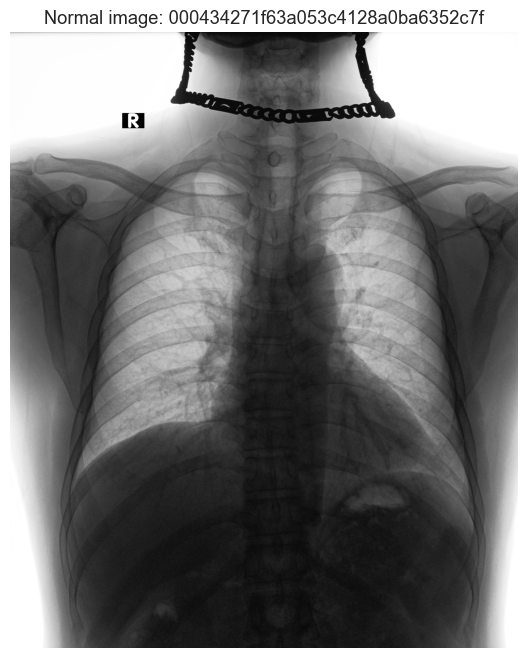

In [20]:
only_no_finding_ids = (
    df.groupby("image_id")["class_name"]
      .agg(lambda x: set(x) == {"No finding"})
)
clean_images = only_no_finding_ids[only_no_finding_ids].index.tolist()
print("Количество полностью нормальных снимков, без комментариев от какого-либо врача:", len(clean_images))

example_id = clean_images[0]
print("Пример нормального image_id:", example_id)
dicom_path = os.path.join(dicom_train_dir, f"{example_id}.dicom")
dicom = pydicom.dcmread(dicom_path)
img = dicom.pixel_array
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min())

plt.figure(figsize=(8, 8))
plt.imshow(img, cmap="gray")
plt.title(f"Normal image: {example_id}")
plt.axis("off")
plt.show()

## Идея:

Будем решать задачу анализа рентгеновских снимков с помощью классического машинного обучения, разбив её на три последовательных шага. Такой подход проще реализовать, и он не требует сложных нейронных сетей.

### Блок-схема решения

1. **Проверка: нормальный снимок или нет**  
   → Используем признаки HOG и LBP со всего изображения  
   → Решаем: Normal (здоровый) или Abnormal (есть проблема)

2. **Если снимок Abnormal — ищем проблемные области**  
   → Делим изображение на небольшие участки  
   → Для каждого участка считаем те же признаки  
   → Находим участки, которые выглядят подозрительно

3. **Определяем, что именно не так**  
   → Классифицируем тип патологии (например, фиброз, консолидация и т.д.)

### Почему начинаем с бинарной классификации?

Исходные данные показывают:
- В среднем на снимке находят 1 патологию
- Около 41% снимков — полностью здоровые
- Класс "No finding" (без находок) — самый частый

Получается, что снимки естественно делятся на "здоровые" и "с проблемами". Поэтому логично сначала отделить одно от другого.

### Преимущества такого подхода

1. **Экономия ресурсов** — второй и третий этапы работают только с проблемными снимками
2. **Меньше ложных срабатываний** — не ищем проблемы там, где их нет
3. **Проще настраивать** — каждая модель решает свою конкретную задачу
4. **Работает как простой фильтр** — сначала отсеиваем здоровых, потом разбираемся с остальными

### Недостатки подхода

- **Ошибка на первом этапе** — если снимок с патологией ошибочно признан здоровым, мы пропустим проблему
- **Избыточность данных для бинарной классификации** — HOG/LBP похожих снимков (все-легкие) не гарантирует качественное использование для бинарной классификации
- **Накопление ошибок** — ошибки на каждом этапе суммируются
- **Менее точная детекция** — классические методы, особенно в виде ансамблевой модели - могут легко уступить моделям на основе CV


Все три этапа можно объединить в одну систему, где они будут работать согласованно и дополнять друг друга.

## II. какие признаки из изображения мы потенциально можем вычленить

Перед тем как строить бинарную модель, важно понять, **какую информацию вообще можно достать из одного рентгеновского снимка** стандартными методами.  
Чтобы ответить на этот вопрос, мы сначала вручную исследовали один примерный DICOM-файл.

### Что мы проверили на одном DICOM-файле

1. **Само изображение**  
   → Те данные, которые позволят по параметрам контрастности, контурам, текстуре и яркости выделить нам переменные для классификации

2. **Все доступные DICOM-метаданные**  
   → убедились, что часть тегов пустые, часть избыточные, а ключевые параметры (pixel spacing, окна, размеры, возраст/пол) действительно присутствуют

После просмотра одного DICOM-файла стало видно, что снимки содержат много информации о:

- форме и контурах лёгких, сердца, диафрагмы  
- текстуре (неоднородности, затемнения, инфильтраты)  
- контрасте и структуре тканей  

Эти вещи хорошо описываются классическими методами CV:

#### 1. **HOG (Histogram of Oriented Gradients)**  
Показывает **форму и большие контуры**.  
Полезно для:
- увеличения тени сердца (cardiomegaly),
- крупных затемнений (consolidation),
- смещений структур.

#### 2. **LBP (Local Binary Patterns)**  
Описывает **локальную текстуру**, хорошо ловит:
- фиброз,
- интерстициальные изменения,
- мелкие неоднородности в лёгких.

#### 3. **GLCM (Gray-Level Co-occurrence Matrix)**  
Характеризует **распределение яркостей** и их совместную встречаемость:  
контраст, однородность, энергия и т.п.

Эти признаки подходят для классических ML-моделей (LogReg, SVM, XGBoost, RF), потому что:

- дают **фиксированный числовой вектор**
- работают на чёрно-белых медицинских снимках
- не требуют больших объёмов данных для обучения

Эти признаки также могут применяться на этапе детекции аномалий на изображении, и их классификации

=== RAW IMAGE SHAPE === (2877, 2271)

=== METADATA ===
(0010,0040) | PatientSex: 
(0028,0002) | SamplesPerPixel: 1
(0028,0004) | PhotometricInterpretation: MONOCHROME2
(0028,0010) | Rows: 2877
(0028,0011) | Columns: 2271
(0028,0030) | PixelSpacing: [0.125, 0.125]
(0028,0100) | BitsAllocated: 16
(0028,0101) | BitsStored: 12
(0028,0102) | HighBit: 11
(0028,0103) | PixelRepresentation: 0
(0028,1050) | WindowCenter: 2048
(0028,1051) | WindowWidth: 4096
(0028,1052) | RescaleIntercept: 0
(0028,1053) | RescaleSlope: 1
(0028,2110) | LossyImageCompression: 00
(7FE0,0010) | PixelData: <13067334 bytes>

=== KEY METADATA ===
PatientSex: 
PatientAge: None
Rows: 2877 Columns: 2271
PixelSpacing: [0.125, 0.125]
WindowCenter: 2048 WindowWidth: 4096
RescaleSlope: 1 RescaleIntercept: 0
PhotometricInterpretation: MONOCHROME2


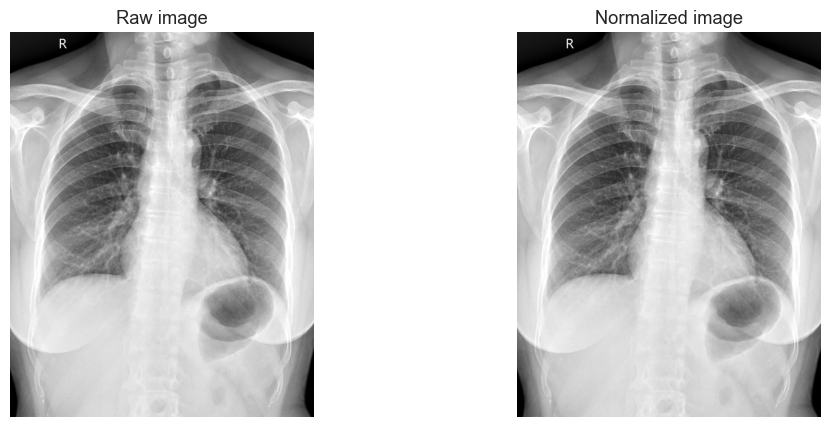

HOG feature vector length: 8100


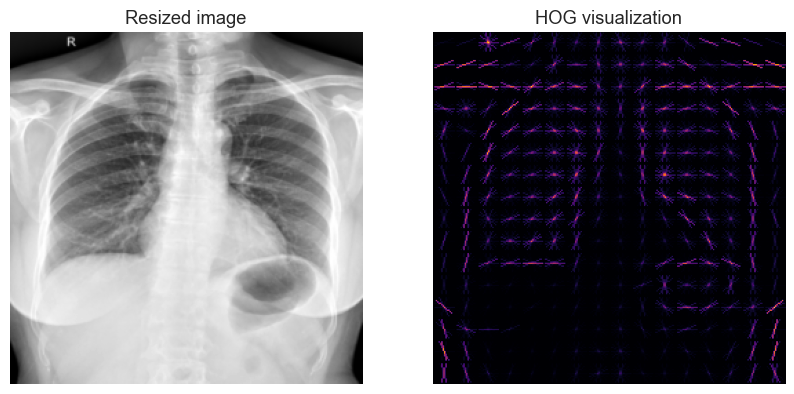

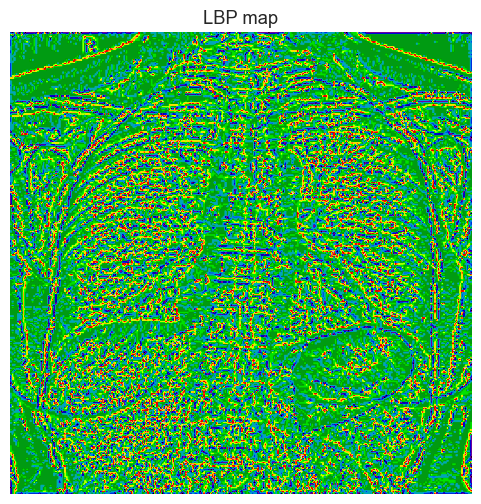

LBP histogram: [ 2528  3690  4158  9112 21280 10353  4387  3155  2301  4572]

=== GLCM FEATURES ===
Contrast: 43.774708946078434
Dissimilarity: 3.909543504901961
Homogeneity: 0.3230431031639492
Energy: 0.027620846774731377
Correlation: 0.9939675428970794


In [25]:
path = "/Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/test/0a1addecfc432a1b425d61fe57bc29d2.dicom"

# --- Загрузка DICOM ---
ds = pydicom.dcmread(path)
img = ds.pixel_array.astype(float)

print("=== RAW IMAGE SHAPE ===", img.shape)

# --- Метаданные ---
print("\n=== METADATA ===")
for elem in ds:
    tag = elem.tag
    name = keyword_for_tag(tag) or elem.name
    val = elem.value
    if isinstance(val, (bytes, bytearray)):
        val = f"<{len(val)} bytes>"
    print(f"{tag} | {name}: {val}")

# --- Ключевые метаданные ---
print("\n=== KEY METADATA ===")
print("PatientSex:", ds.get("PatientSex"))
print("PatientAge:", ds.get("PatientAge"))
print("Rows:", ds.get("Rows"), "Columns:", ds.get("Columns"))
print("PixelSpacing:", ds.get("PixelSpacing"))
print("WindowCenter:", ds.get("WindowCenter"), "WindowWidth:", ds.get("WindowWidth"))
print("RescaleSlope:", ds.get("RescaleSlope"), "RescaleIntercept:", ds.get("RescaleIntercept"))
print("PhotometricInterpretation:", ds.get("PhotometricInterpretation"))

# --- Подготовка изображения ---
if ds.get("PhotometricInterpretation", "") == "MONOCHROME1":
    img = img.max() - img

img_norm = img - img.min()
if img_norm.max() > 0:
    img_norm = img_norm / img_norm.max()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_norm, cmap="gray")
plt.title("Normalized image")
plt.axis("off")
plt.show()

# --- HOG + визуализация ---
IMG_SIZE = 256
img_resized = resize(img_norm, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)

hog_vec, hog_image = hog(
    img_resized,
    orientations=9,
    pixels_per_cell=(16,16),
    cells_per_block=(2,2),
    block_norm='L2-Hys',
    visualize=True
)

print("HOG feature vector length:", len(hog_vec))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_resized, cmap="gray")
plt.title("Resized image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap="inferno")
plt.title("HOG visualization")
plt.axis("off")
plt.show()

# --- LBP карта + гистограмма ---
lbp = local_binary_pattern(img_resized, P=8, R=1, method="uniform")
plt.figure(figsize=(6,6))
plt.imshow(lbp, cmap="nipy_spectral")
plt.title("LBP map")
plt.axis("off")
plt.show()

lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11))
print("LBP histogram:", lbp_hist)

# --- GLCM текстурные признаки ---
# Переводим в uint8 0–255
glcm_img = (img_resized * 255).astype(np.uint8)

glcm = graycomatrix(
    glcm_img,
    distances=[1],
    angles=[0],
    levels=256,
    symmetric=True,
    normed=True
)

contrast = graycoprops(glcm, 'contrast')[0,0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0,0]
homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
energy = graycoprops(glcm, 'energy')[0,0]
correlation = graycoprops(glcm, 'correlation')[0,0]

print("\n=== GLCM FEATURES ===")
print("Contrast:", contrast)
print("Dissimilarity:", dissimilarity)
print("Homogeneity:", homogeneity)
print("Energy:", energy)
print("Correlation:", correlation)

## III. сбор и выделение метаданных

В самих данных можно работать как с изображениями, так и с их метаданными - для начала оценим метаданные трейн и тест датасетов - оставим только те метаданные, которые более-менее одинаково существуют в обоих датасетах

выделим наиболее интересные, и встречающиеся в обоих датасетах метаданные, предобработаем их

In [27]:
def data_element_to_dict(data_element):
    """
    Преобразует один DICOM-элемент в словарь.
    Pixel Data пропускаем.
    SEQUENCE (VR='SQ') разворачиваем рекурсивно.
    """
    d = collections.OrderedDict()

    # Пропускаем большие данные
    if data_element.name == "Pixel Data":
        return d

    # SEQUENCE → рекурсивно
    if data_element.VR == "SQ":
        items = collections.OrderedDict()
        for i, dataset_item in enumerate(data_element):
            items[f"item_{i}"] = dataset_to_dict(dataset_item)
        d[data_element.name] = items
        return d

    # Обычный тег
    d[data_element.name] = data_element.value
    return d


def dataset_to_dict(dataset):
    """
    Разворачивает весь DICOM Dataset (file_meta + обычные теги) в один dict.
    """
    d = {}

    # File Meta
    for de in dataset.file_meta:
        d.update(data_element_to_dict(de))

    # Основные теги
    for de in dataset:
        d.update(data_element_to_dict(de))

    return d


def dicom_folder_to_dataframe(folder, limit=None):
    """
    Пробегается по папке с .dcm/.dicom и возвращает DataFrame
    с полным набором метаданных. Все предупреждения pydicom
    (в т.ч. про VR UI) подавляются внутри.
    
    folder: путь к папке с DICOM
    limit:  если не None — обрабатываем только первые N файлов
    """
    # собираем список файлов
    files = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".dcm", ".dicom"))
    ]

    files = sorted(files)
    if limit is not None:
        files = files[:limit]

    print(f"Найдено DICOM-файлов в {folder}: {len(files)}")

    series_list = []

    for fpath in tqdm(files, desc=f"Extracting DICOM metadata from: {folder}"):
        try:
            # глушим UserWarning (в т.ч. про невалидный VR UI)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                ds = pydicom.dcmread(fpath, stop_before_pixels=True, force=True)

            d = dataset_to_dict(ds)
            # индекс — имя файла без расширения
            d["filename"] = ntpath.basename(fpath).replace(".dicom", "").replace(".dcm", "")
            series_list.append(pd.Series(d))

        except Exception as e:
            # просто логируем и идём дальше
            print(f"[WARN] Ошибка чтения файла {fpath}: {e}")
            continue

    if not series_list:
        print("Не удалось прочитать ни одного файла.")
        return pd.DataFrame()

    print("Converting to DataFrame...")
    df = pd.concat([pd.DataFrame(s).T for s in series_list], ignore_index=True)
    df = df.set_index("filename")
    return df

In [30]:
dicom_train_dir = os.path.join(data_dir, "train")
dicom_test_dir  = os.path.join(data_dir, "test")

# можно сначала протестировать на 300–500 файлов:
# df_train_meta = dicom_folder_to_dataframe(dicom_train_dir, limit=500)

df_train_meta = dicom_folder_to_dataframe(dicom_train_dir)
df_test_meta  = dicom_folder_to_dataframe(dicom_test_dir)

df_train_meta.to_csv("train_dicom_metadata_full.csv")
df_test_meta.to_csv("test_dicom_metadata_full.csv")

Найдено DICOM-файлов в /Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/train: 15000


Extracting DICOM metadata from: /Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/train: 100%|██████████| 15000/15000 [00:07<00:00, 2065.14it/s]


Converting to DataFrame...
Найдено DICOM-файлов в /Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/test: 3000


Extracting DICOM metadata from: /Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/test: 100%|██████████| 3000/3000 [00:01<00:00, 2023.12it/s]


Converting to DataFrame...


In [40]:
train_fill = 1 - df_train_meta.isna().mean()
test_fill  = 1 - df_test_meta.isna().mean()

df_fill = pd.DataFrame({
    "train_fill_rate": train_fill,
    "test_fill_rate": test_fill
}).sort_values("train_fill_rate", ascending=False)

df_fill

,train_fill_rate,test_fill_rate
Bits Allocated,1.000000,1.000000
Media Storage SOP Class UID,1.000000,1.000000
Transfer Syntax UID,1.000000,1.000000
Samples per Pixel,1.000000,1.000000
Rows,1.000000,1.000000
Pixel Representation,1.000000,1.000000
Photometric Interpretation,1.000000,1.000000
Bits Stored,1.000000,1.000000
Media Storage SOP Instance UID,1.000000,1.000000
Patient's Sex,1.000000,1.000000


In [82]:
train_only = set(df_train_meta.columns) - set(df_test_meta.columns)
print("Признаки, которые есть ТОЛЬКО в train:", train_only)
test_only = set(df_test_meta.columns) - set(df_train_meta.columns)
print("Признаки, которые есть ТОЛЬКО в test:", test_only)
common_features = sorted(set(df_train_meta.columns) & set(df_test_meta.columns))
print("Общие признаки:", len(common_features))
common_features

Признаки, которые есть ТОЛЬКО в train: set()
Признаки, которые есть ТОЛЬКО в test: set()
Общие признаки: 32


['Bits Allocated',
 'Bits Stored',
 'Columns',
 'File Meta Information Group Length',
 'File Meta Information Version',
 'High Bit',
 'Implementation Class UID',
 'Implementation Version Name',
 'Largest Image Pixel Value',
 'Lossy Image Compression',
 'Lossy Image Compression Method',
 'Lossy Image Compression Ratio',
 'Media Storage SOP Class UID',
 'Media Storage SOP Instance UID',
 'Number of Frames',
 "Patient's Age",
 "Patient's Sex",
 "Patient's Size",
 "Patient's Weight",
 'Photometric Interpretation',
 'Pixel Aspect Ratio',
 'Pixel Representation',
 'Pixel Spacing',
 'Rescale Intercept',
 'Rescale Slope',
 'Rows',
 'Samples per Pixel',
 'Smallest Image Pixel Value',
 'Source Application Entity Title',
 'Transfer Syntax UID',
 'Window Center',
 'Window Width']

In [42]:
df_fill["abs_diff"] = (df_fill.train_fill_rate - df_fill.test_fill_rate).abs()
df_fill_sorted = df_fill.sort_values("abs_diff", ascending=False)

df_fill_sorted.head(20)

,train_fill_rate,test_fill_rate,abs_diff
Source Application Entity Title,0.594733,0.743333,0.148600
Pixel Spacing,0.856533,0.932000,0.075467
Patient's Age,0.365400,0.294000,0.071400
Number of Frames,0.198800,0.217667,0.018867
Rescale Slope,0.818800,0.804667,0.014133
Rescale Intercept,0.818800,0.804667,0.014133
Lossy Image Compression Ratio,0.038400,0.025333,0.013067
Lossy Image Compression,0.924733,0.937000,0.012267
Largest Image Pixel Value,0.110600,0.098667,0.011933
Smallest Image Pixel Value,0.110600,0.098667,0.011933


In [55]:
def make_hashable(x):
    """Приводит любые сложные структуры DICOM в hashable представление."""
    if isinstance(x, (list, tuple)):
        return tuple(make_hashable(v) for v in x)
    if isinstance(x, dict):
        return str(x)
    if isinstance(x, set):
        return tuple(sorted(x))
    return x
  
df_train = pd.read_csv("train_dicom_metadata_full.csv")
df_test  = pd.read_csv("test_dicom_metadata_full.csv")

def preprocess_df(df):
    df = df.copy()

    for col in df.columns:
        # MultiValue / списки / dict → строка
        df[col] = df[col].apply(
            lambda x: str(x) if isinstance(x, (list, tuple, dict)) else x
        )
    return df

df_train_p = preprocess_df(df_train)
df_test_p  = preprocess_df(df_test)


# === 1. Доля заполненности ===
train_fill = (df_train_p.notna().mean()).rename("train_fill_rate")
test_fill  = (df_test_p.notna().mean()).rename("test_fill_rate")

fill_df = pd.concat([train_fill, test_fill], axis=1)
fill_df["abs_diff"] = (fill_df["train_fill_rate"] - fill_df["test_fill_rate"]).abs()
fill_df = fill_df.sort_values("abs_diff", ascending=False)


# === 2. Число уникальных значений (без ошибок MultiValue) ===
def safe_nunique(series):
    try:
        return series.nunique(dropna=True)
    except TypeError:
        # например "MultiValue([0.140, 0.140])"
        return series.astype(str).nunique(dropna=True)

uni_train = df_train_p.apply(safe_nunique).rename("train_nunique")
uni_test  = df_test_p.apply(safe_nunique).rename("test_nunique")

uni_df = pd.concat([uni_train, uni_test], axis=1)


# === 3. Объединённый отчёт ===
summary = fill_df.join(uni_df)
summary

,train_fill_rate,test_fill_rate,abs_diff,train_nunique,test_nunique
Source Application Entity Title,0.594733,0.743333,0.148600,5,5
Implementation Version Name,0.582267,0.474000,0.108267,4,3
Pixel Spacing,0.856533,0.932000,0.075467,11,11
Patient's Age,0.358133,0.288333,0.069800,103,91
Lossy Image Compression,0.828733,0.850000,0.021267,1,1
Number of Frames,0.198800,0.217667,0.018867,1,1
Rescale Intercept,0.818800,0.804667,0.014133,1,1
Rescale Slope,0.818800,0.804667,0.014133,1,1
Lossy Image Compression Ratio,0.038400,0.025333,0.013067,1,1
Largest Image Pixel Value,0.110600,0.098667,0.011933,1,1


### Какие DICOM-фичи оставляем

Мы оставляем только теги, которые есть и в train, и в test, и реально относятся к самому изображению или пациенту.

**Технические (геометрия и окно изображения- могут пригодится при обработке самих изображений):**
- `Rows`, `Columns` — размер снимка  
- `Pixel Spacing (px_sp_x, px_sp_y)` — размер (пикселя)
- `Window Center`, `Window Width` — параметры отображения

**Пациентские:**
- `Patient's Age`  
- `Patient's Sex`

**Аппаратные (оставляем в данных, но не используем в модели):**
- `Source Application Entity Title`  
- `Implementation Version Name`  

Аппарат и рабочая станция могут влиять на визуальные свойства картинок и на вердикт врачей (разные ПО, фильтры), хоть существует риск, что модель может начать “угадывать аппарат”, а не патологию - все-равно я допускаю предрасположенность применения определенных рентгенаппаратов при диагностики определенной категории больных лиц. потому пока оставляем

### Что исключаем

- `Transfer Syntax UID` и подобные — это кодеки/форматы хранения, не характеристики снимка.  
  Они могут дать модели нечестный сигнал и ухудшить обобщаемость.

### Что идёт в baseline (Normal vs Abnormal)

Используем только безопасные, стабильные признаки:
- `Rows`, `Columns`
- `px_sp_x`, `px_sp_y`
- `Window Center`, `Window Width`
- `Patient's Age`, `Patient's Sex`
- `Source Application Entity Title`, `Implementation Version Name`



=== Train missing rates ===
age                                0.749333
px_sp_x                            0.143467
px_sp_y                            0.143467
Window Center                      0.028200
Window Width                       0.028200
filename                           0.000000
Rows                               0.000000
Columns                            0.000000
Source Application Entity Title    0.000000
Implementation Version Name        0.000000
sex_cat                            0.000000
dtype: float64

=== Test missing rates ===
age                                0.845333
px_sp_x                            0.068000
px_sp_y                            0.068000
Window Center                      0.019667
Window Width                       0.019667
filename                           0.000000
Rows                               0.000000
Columns                            0.000000
Source Application Entity Title    0.000000
Implementation Version Name        0.000000
sex_c

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


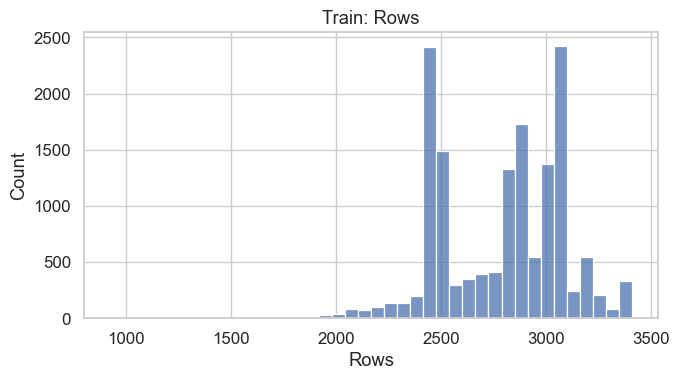

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


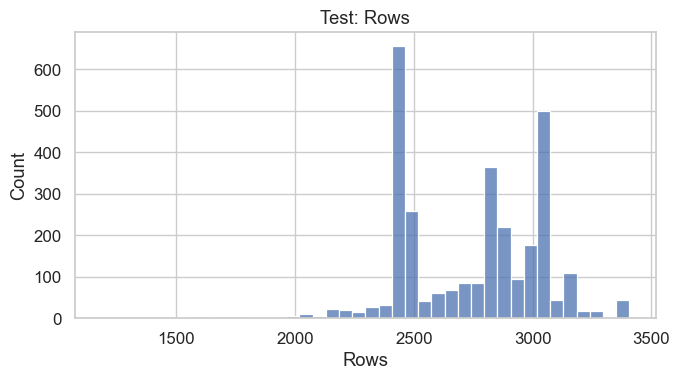

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


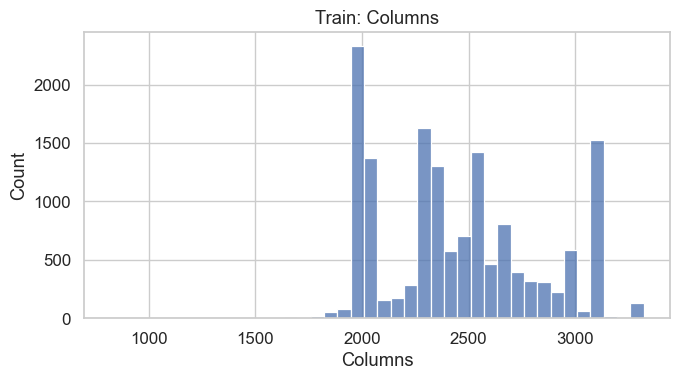

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


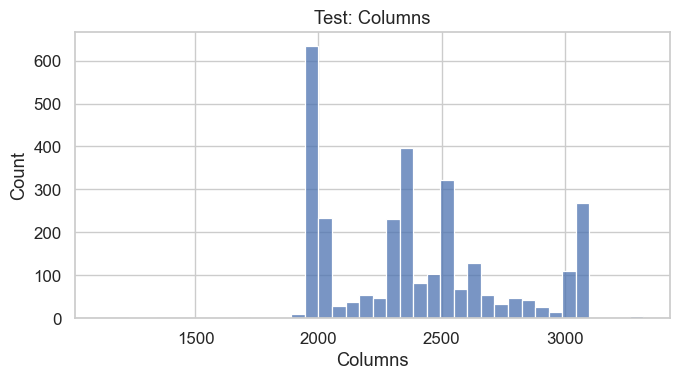

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


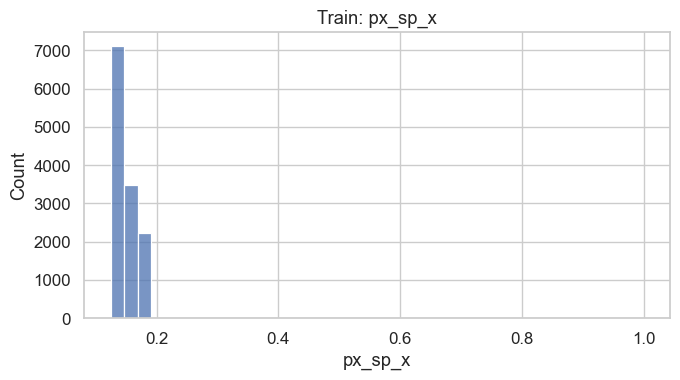

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


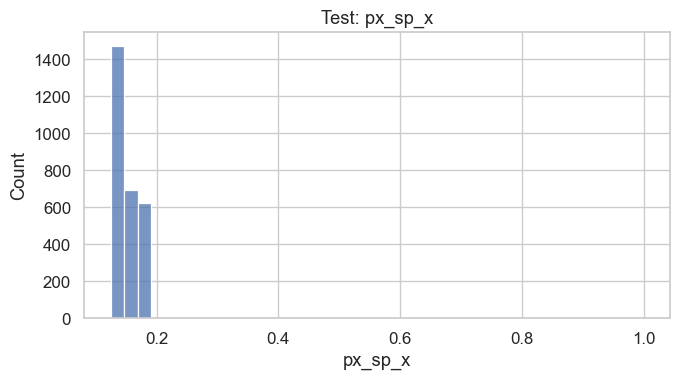

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


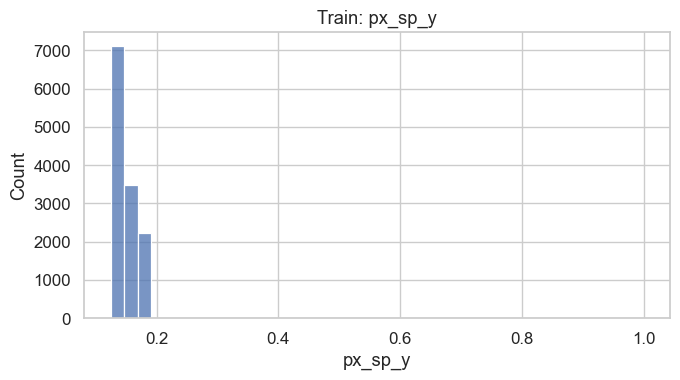

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


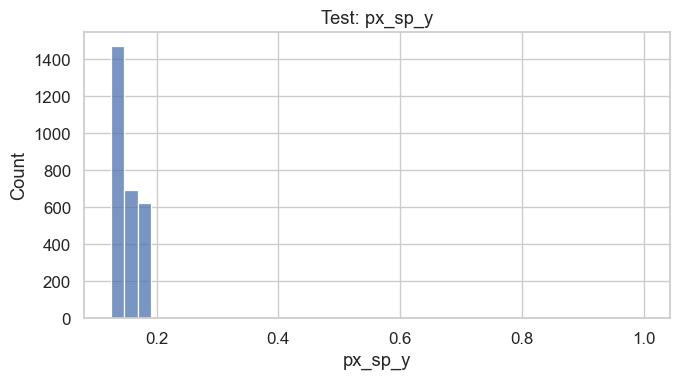

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


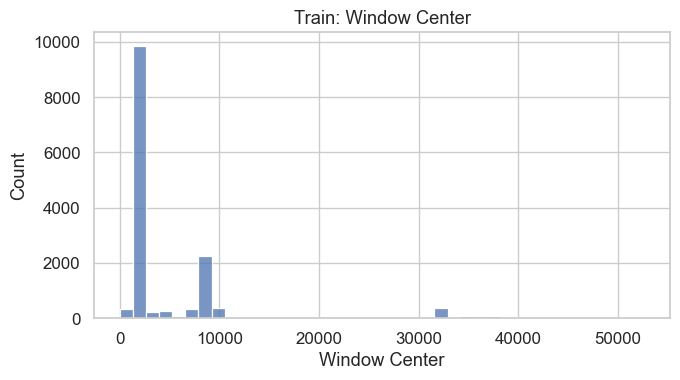

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


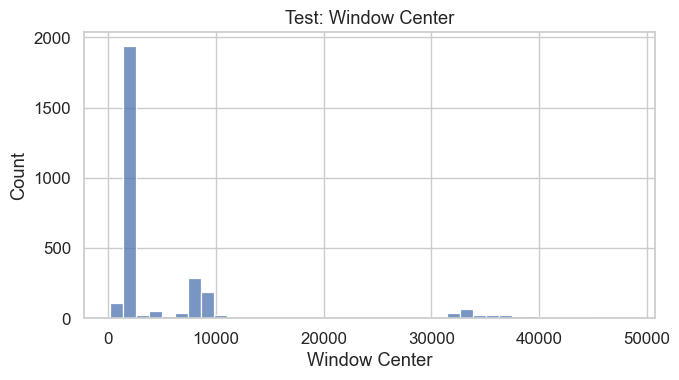

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


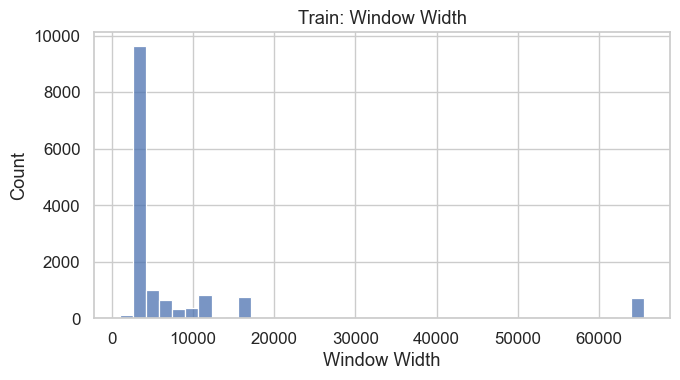

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


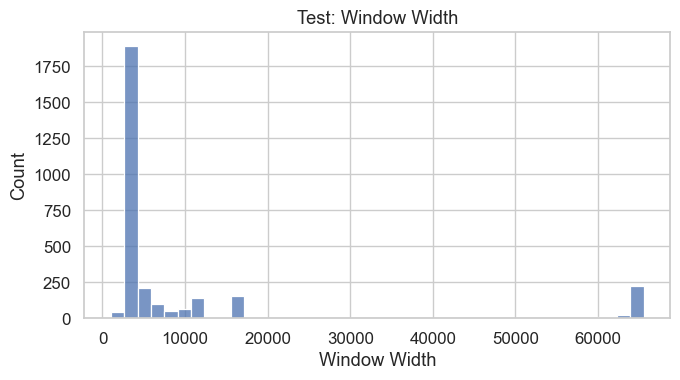

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


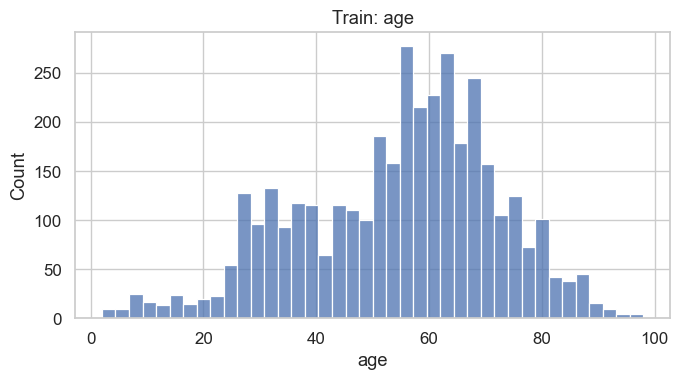

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


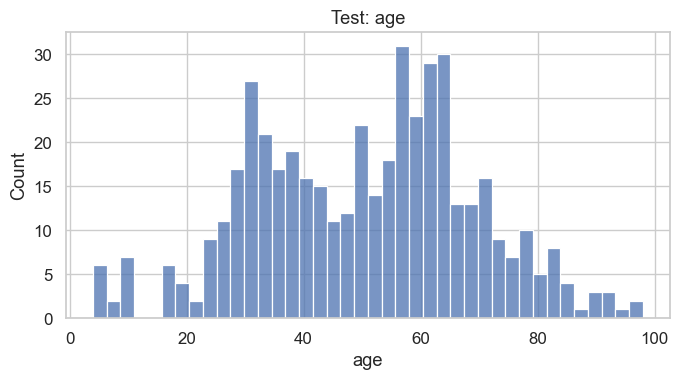

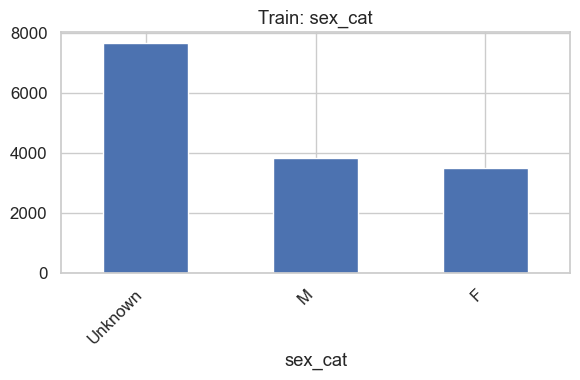

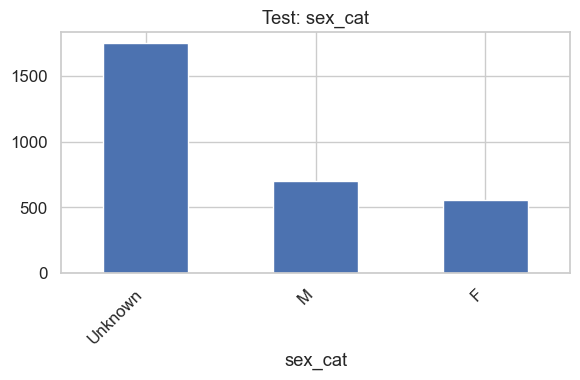

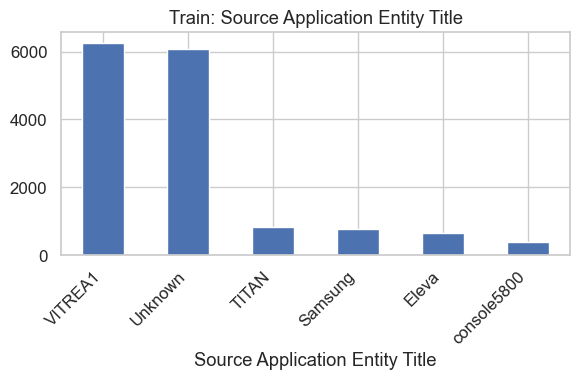

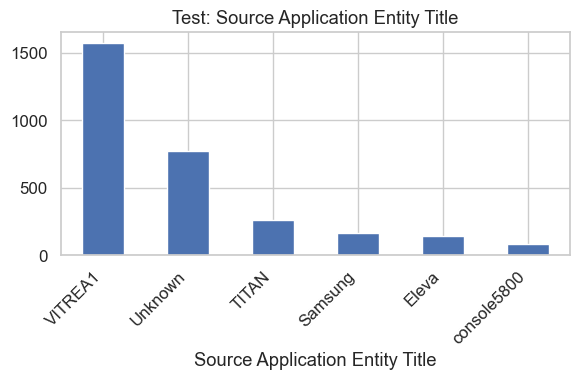

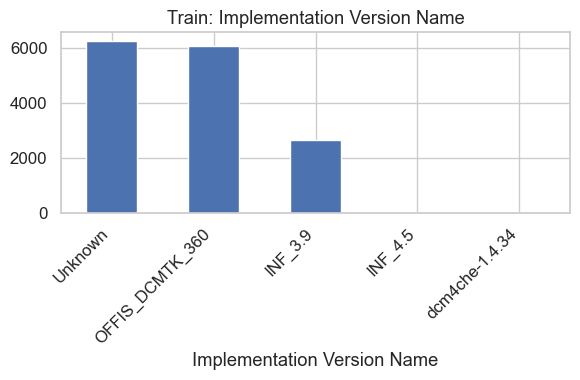

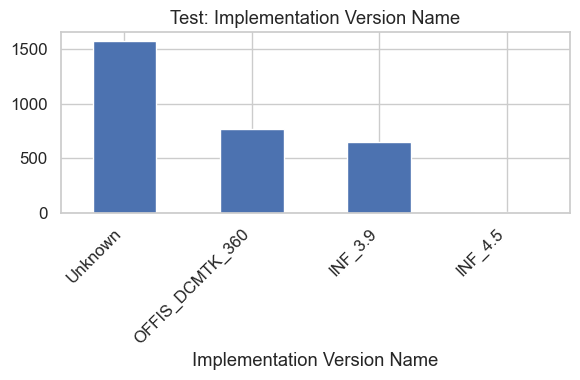

,filename,Rows,Columns,Window Center,Window Width,Source Application Entity Title,Implementation Version Name,px_sp_x,px_sp_y,age,sex_cat
0,000434271f63a053c4128a0ba6352c7f,2836,2336,2047.0,4095.0,VITREA1,Unknown,0.150,0.150,NaN,Unknown
1,00053190460d56c53cc3e57321387478,2430,1994,2047.0,4096.0,VITREA1,Unknown,0.175,0.175,NaN,Unknown
2,0005e8e3701dfb1dd93d53e2ff537b6e,3072,3072,8483.0,11160.0,Unknown,OFFIS_DCMTK_360,0.140,0.140,28.0,F
3,0006e0a85696f6bb578e84fafa9a5607,3000,3000,2047.0,4095.0,Eleva,INF_3.9,NaN,NaN,NaN,F
4,0007d316f756b3fa0baea2ff514ce945,2880,2304,2047.0,4095.0,Unknown,OFFIS_DCMTK_360,0.150,0.150,NaN,M


In [78]:
df_train_raw = pd.read_csv("train_dicom_metadata_full.csv")
df_test_raw  = pd.read_csv("test_dicom_metadata_full.csv")

final_cols = [
    "filename",
    "Rows",
    "Columns",
    "Pixel Spacing",
    "Window Center",
    "Window Width",
    "Patient's Age",
    "Patient's Sex",
    "Source Application Entity Title",
    "Implementation Version Name",
]

df_train = df_train_raw[final_cols].copy()
df_test  = df_test_raw[final_cols].copy()

def clean_val(v):
    if isinstance(v, str):
        vs = v.strip()
        if vs == "" or vs.lower() in ["none", "nan", "null"]:
            return np.nan
        return vs
    return v

for df in [df_train, df_test]:
    for col in df.columns:
        df[col] = df[col].apply(clean_val)

# =======================
# 2. Pixel Spacing → два числа
# =======================
def parse_pixel_spacing(v):
    if isinstance(v, str):
        try:
            v = v.replace("[","").replace("]","")
            parts = [p.strip() for p in v.split(",")]
            if len(parts) == 2:
                return float(parts[0]), float(parts[1])
        except:
            pass
    return np.nan, np.nan

for df in [df_train, df_test]:
    df["px_sp_x"], df["px_sp_y"] = zip(*df["Pixel Spacing"].apply(parse_pixel_spacing))
    df.drop(columns=["Pixel Spacing"], inplace=True)

# =======================
# Возраст: 0 и явно странные значения → NaN
# =======================
def parse_age(v):
    if isinstance(v, str) and v.endswith("Y"):
        try:
            a = int(v[:-1])
            # считаем нормальным диапазон 1–110
            if 1 <= a <= 110:
                return a
            return np.nan
        except:
            return np.nan
    return np.nan

for df in [df_train, df_test]:
    df["age"] = df["Patient's Age"].apply(parse_age).astype("float")
    df.drop(columns=["Patient's Age"], inplace=True)

# =======================
# Пол: M/F/Unknown
# =======================
def parse_sex(v):
    if v == "M": return "M"
    if v == "F": return "F"
    return "Unknown"

for df in [df_train, df_test]:
    df["sex_cat"] = df["Patient's Sex"].apply(parse_sex)
    df.drop(columns=["Patient's Sex"], inplace=True)

# =======================
# Окно изображения: float
# =======================
def to_float(v):
    try:
        return float(v)
    except:
        return np.nan

for df in [df_train, df_test]:
    df["Window Center"] = df["Window Center"].apply(to_float)
    df["Window Width"]  = df["Window Width"].apply(to_float)

# =======================
# Категориальные поля аппарата
# =======================
for df in [df_train, df_test]:
    df["Source Application Entity Title"] = df["Source Application Entity Title"].fillna("Unknown")
    df["Implementation Version Name"]     = df["Implementation Version Name"].fillna("Unknown")

# =======================
# Быстрый отчёт по пропускам
# =======================
print("=== Train missing rates ===")
print(df_train.isna().mean().sort_values(ascending=False))
print("\n=== Test missing rates ===")
print(df_test.isna().mean().sort_values(ascending=False))

# =======================
# Визуализации
# =======================
def plot_hist(df, col, title):
    plt.figure(figsize=(7,4))
    sns.histplot(df[col].dropna(), bins=40)
    plt.title(title)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

def plot_bar(df, col, title):
    plt.figure(figsize=(6,4))
    df[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

num_cols = ["Rows", "Columns", "px_sp_x", "px_sp_y", "Window Center", "Window Width", "age"]
for col in num_cols:
    plot_hist(df_train, col, f"Train: {col}")
    plot_hist(df_test,  col, f"Test: {col}")

cat_cols = ["sex_cat", "Source Application Entity Title", "Implementation Version Name"]
for col in cat_cols:
    plot_bar(df_train, col, f"Train: {col}")
    plot_bar(df_test,  col, f"Test: {col}")

# =======================
# Сохраняем финальные метаданные
# =======================
df_train_meta_clean = df_train.copy()
df_test_meta_clean  = df_test.copy()

df_train_meta_clean.to_csv("train_dicom_meta_clean.csv", index=False)
df_test_meta_clean.to_csv("test_dicom_meta_clean.csv", index=False)

df_train_meta_clean.head()

In [80]:
x_train_clean_metadata = df_train_meta_clean.copy()
x_test_clean_metadata  = df_test_meta_clean.copy()

x_train_clean_metadata.to_csv("x_train_clean_metadata.csv", index=False)
x_test_clean_metadata.to_csv("x_test_clean_metadata.csv", index=False)

 ##  IV. Генерация целевых переменных для каждого изображения

 Как уже проговорили- мы ставим **бинарный таргет** :
 
**0** — если ВСЕ аннотации только "No finding"

**1** — если есть хотя бы одна выявленная врачом патология


исходя из того, что только для трейн- данных мы знаем эту классификацию - объединяем и работаем с таким датасетом

In [90]:
df_ann = pd.read_csv(train_csv_path)                 # исходный kaggle train с bbox и классами
x_train_meta = pd.read_csv("x_train_clean_metadata.csv") # то, что мы уже подготовили

classes_set_per_image = (
    df_ann.groupby("image_id")["class_name"]
          .agg(set)
)

#Бинарный таргет:
#0 — если ВСЕ аннотации только "No finding"
#1 — если есть хотя бы одна другая патология
y_binary = (classes_set_per_image != {"No finding"}).astype(int)
y_binary = y_binary.rename("target_binary").reset_index()

print("Распределение таргета (0=No finding, 1=Abnormal):")
print(y_binary["target_binary"].value_counts())

# 4. Приводим метаданные к тому же ключу (image_id без .dicom)
x_train_meta = x_train_meta.copy()
x_train_meta["image_id"] = x_train_meta["filename"].str.replace(".dicom", "", regex=False)

# 5. Джоин: метаданные + бинарный таргет
train_binary_meta = x_train_meta.merge(y_binary, on="image_id", how="inner")

print("Форма итогового train-датафрейма:", train_binary_meta.shape)

Распределение таргета (0=No finding, 1=Abnormal):
target_binary
0    10606
1     4394
Name: count, dtype: int64
Форма итогового train-датафрейма: (15000, 13)


In [94]:
train_binary_meta.to_csv("train_binary_with_meta.csv", index=False)

## V. Извлечение признаков из изображений (HOG, LBP, GLCM)

На этом этапе мы формируем отдельный набор признаков, рассчитанных **не из метаданных**, а напрямую из пиксельных данных каждого DICOM-снимка.  
Это необходимо для того, чтобы классические ML-модели могли работать со структурой изображения, в достаточной для бинарной классификации мере

**Что извлекаем:**
- **HOG (Histogram of Oriented Gradients)** — признаки градиентов, отражают форму и контуры лёгких.  
- **LBP (Local Binary Patterns)** — текстурные признаки, фиксируют неоднородности и мелкие структуры.  
- **GLCM (Gray Level Co-occurrence Matrix)** — 6 статистик совместной встречаемости яркостей (контраст, энергия и др.).  
- **Статистики интенсивности** — среднее, стандартное отклонение, минимум, максимум, энтропия.

**Зачем это нужно:**
- Позволяет обучить модели Logistic Regression, SVM, Random Forest, XGBoost на признаках, построенных напрямую из изображения.  
- Даёт компактное числовое представление снимка без использования CNN.  
- Подходит для задачи бинарной классификации (Normal vs Abnormal) и для будущего этапа детекции.

В результате получаем два датафрейма:

- `x_train_image_features.csv` — признаки изображений на тренировочных данных  
- `x_test_image_features.csv` — признаки изображений на тестовых данных

Эти данные затем будут объединены с очищенными DICOM-метаданными.

In [84]:
data_dir='/Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection'
train_csv_path = os.path.join(data_dir, "train.csv")
dicom_train_dir = os.path.join(data_dir, "train")
dicom_test_dir = os.path.join(data_dir, "test")

IMG_SIZE = 256
LBP_P = 8
LBP_R = 1

# ===================================================
# 1. Считывание изображения
# ===================================================
def load_dicom_image(path):
    try:
        ds = pydicom.dcmread(path, stop_before_pixels=False)
    except Exception:
        return None

    try:
        img = ds.pixel_array.astype(np.float32)
    except Exception:
        return None

    # Инверсия MONOCHROME1
    try:
        if getattr(ds, "PhotometricInterpretation", "") == "MONOCHROME1":
            img = img.max() - img
    except Exception:
        pass

    # Нормализация
    m, M = img.min(), img.max()
    if M > m:
        img = (img - m) / (M - m)

    return img


# ===================================================
# 2. Извлечение признаков (с защитой от ошибок)
# ===================================================
def extract_image_features(img):
    try:
        # Resize
        img_resized = resize(img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)

        # ---------- HOG ----------
        hog_vec = hog(
            img_resized,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            feature_vector=True
        ).astype(np.float32)

        # ---------- LBP (исправлено: uint8 вход) ----------
        lbp_input = (img_resized * 255).astype(np.uint8)
        lbp = local_binary_pattern(lbp_input, P=LBP_P, R=LBP_R, method="uniform")

        lbp_hist, _ = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, LBP_P + LBP_R + 3),
            range=(0, LBP_P + LBP_R + 2)
        )
        lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-8)

        # ---------- GLCM ----------
        glcm_img = (img_resized * 255).astype(np.uint8)
        glcm = graycomatrix(
            glcm_img, distances=[1], angles=[0],
            levels=256, symmetric=True, normed=True,
        )

        glcm_feats = {
            "glcm_contrast":      graycoprops(glcm, "contrast")[0, 0],
            "glcm_dissimilarity": graycoprops(glcm, "dissimilarity")[0, 0],
            "glcm_homogeneity":   graycoprops(glcm, "homogeneity")[0, 0],
            "glcm_energy":        graycoprops(glcm, "energy")[0, 0],
            "glcm_correlation":   graycoprops(glcm, "correlation")[0, 0],
            "glcm_asm":           graycoprops(glcm, "ASM")[0, 0],
        }

        # ---------- Simple stats ----------
        stats = {
            "mean_intensity": float(img_resized.mean()),
            "std_intensity":  float(img_resized.std()),
            "min_intensity":  float(img_resized.min()),
            "max_intensity":  float(img_resized.max()),
        }

        feats = {}
        feats.update(stats)
        feats.update(glcm_feats)

        feats.update({f"hog_{i}": float(hog_vec[i]) for i in range(len(hog_vec))})
        feats.update({f"lbp_{i}": float(lbp_hist[i]) for i in range(len(lbp_hist))})

        return feats

    except Exception:
        # Любая ошибка → пропускаем файл
        return None


# ===================================================
# 3. Worker — полностью защищён от ошибок
# ===================================================
def process_one(path):
    try:
        img = load_dicom_image(path)
        if img is None:
            return None

        feats = extract_image_features(img)
        if feats is None:
            return None

        feats["filename"] = (
            os.path.basename(path)
                .replace(".dicom", "")
                .replace(".dcm", "")
        )
        return feats

    except Exception:
        return None


# ===================================================
# 4. Параллельное извлечение
# ===================================================
def extract_folder_features_parallel(folder, n_jobs=4):
    files = sorted([
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".dcm", ".dicom"))
    ])

    print(f"Параллельная обработка {len(files)} файлов...")

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(process_one)(fp) for fp in tqdm(files)
    )

    results = [x for x in results if x is not None]
    return pd.DataFrame(results)

In [88]:
# ===================================================
#   ЗАПУСК ДЛЯ TRAIN / TEST
# ===================================================
# df_train_img = extract_folder_features_parallel(dicom_train_dir, n_jobs=4)
# df_test_img  = extract_folder_features_parallel(dicom_test_dir,  n_jobs=4)
# df_train_img.to_csv("x_train_image_features.csv", index=False)
# df_test_img.to_csv("x_test_image_features.csv", index=False)

# print("Готово! Сохранено:")
# print(" - x_train_image_features.csv")
# print(" - x_test_image_features.csv")

Found 15000 DICOM files in /Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/train


Processing /Users/mark/.cache/kagglehub/competitions/vinbigdata-chest-xray-abnormalities-detection/train:  47%|████▋     | 7046/15000 [36:47<41:32,  3.19it/s]  


KeyboardInterrupt: 

## в рамках обучения модели бинарной классификации мы работаем только с трейн датасетом, где известна бинарная классификация, на ней будем выделять val-часть для отладки моделей

In [115]:
df_meta = pd.read_csv("train_binary_with_meta.csv")
df_img  = pd.read_csv("x_train_image_features.csv")

print("meta shape:", df_meta.shape)
print("img  shape:", df_img.shape)
print(df_meta.columns)
print(df_img.columns)

# 2. Приводим ключи к одному виду
# В meta: image_id и filename уже без расширения
# В img: есть filename → делаем из него image_id

df_img = df_img.copy()
df_img["image_id"] = (
    df_img["filename"]
    .astype(str)
    .str.replace(".dicom", "", regex=False)
    .str.replace(".dcm", "", regex=False)
)

# 3. Джойн по image_id
df_train_full = df_meta.merge(df_img, on="image_id", how="inner", suffixes=("_meta", "_img"))
print("Final merged shape:", df_train_full.shape)
print("Rows lost during merge:", len(df_meta) - len(df_train_full))


meta shape: (15000, 13)
img  shape: (15000, 8122)
Index(['filename', 'Rows', 'Columns', 'Window Center', 'Window Width',
       'Source Application Entity Title', 'Implementation Version Name',
       'px_sp_x', 'px_sp_y', 'age', 'sex_cat', 'image_id', 'target_binary'],
      dtype='object')
Index(['mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity',
       'glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity',
       'glcm_energy', 'glcm_correlation', 'glcm_asm',
       ...
       'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9',
       'lbp_10', 'filename'],
      dtype='object', length=8122)
Final merged shape: (15000, 8135)
Rows lost during merge: 0


In [131]:
# --- Проверяем дубли по ИМЕНИ колонки (быстро) ---
dup_names = df_train_full.columns[df_train_full.columns.duplicated()].tolist()
print("Duplicate column names:", dup_names)

# Обычно здесь только filename с суффиксами. Посмотрим, что есть:
print([c for c in df_train_full.columns if "filename" in c])

# 4. Удаляем очевидные лишние колонки
cols_to_drop = []

# если есть обе версии filename — оставим одну
if "filename_img" in df_train_full.columns:
    cols_to_drop.append("filename_img")
if "filename" in df_train_full.columns:
    # если исходный merge не добавил суффиксы, filename дублирует image_id по смыслу
    cols_to_drop.append("filename")

df_train_full_clean = df_train_full.drop(columns=cols_to_drop, errors="ignore")

print("Dropped:", cols_to_drop)
print("Final shape:", df_train_full_clean.shape)

df_train_full_clean.to_csv("train_full_dataset.csv", index=False)
print("Saved: train_full_dataset.csv")

Duplicate column names: []
['filename_meta', 'filename_img']
Dropped: ['filename_img']
Final shape: (15000, 8134)
Saved: train_full_dataset.csv
